# Comparing Site Definitions: Basic Ion Migration in a FCC Lattice

## Introduction

This tutorial demonstrates how to track ion migration through a face-centered cubic (FCC) lattice using three different approaches for site definition:

1. **Spherical Sites**: Simple spheres centered at interstitial positions
2. **Voronoi Sites**: Space-filling cells based on proximity to site centers
3. **Polyhedral Sites**: Sites defined by coordination polyhedra

We will analyse a simple trajectory where a single lithium ion follows a curved path from an octahedral site, through a tetrahedral site, to another octahedral site in an fcc oxygen lattice. This trajectory mimics a common diffusion mechanism in close-packed structures.

This tutorial illustrates:
- How to set up different site definitions using the TrajectoryBuilder
- The tradeoffs between different site definition approaches
- How site definitions affect the analysis of ion migration paths

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Lattice, Structure, DummySpecies
from site_analysis import TrajectoryBuilder

# custom figure settings
from figure_formatting import figure_formatting as ff
ff.set_formatting()
%config InlineBackend.figure_format='retina'

## Creating a FCC Lattice

First, we create a 3×3×3 fcc oxygen lattice, which will serve as our host framework. 

In [2]:
a = 4.0 # lattice parameter
lattice = Lattice.cubic(a)
supercell_expansion = [3,3,3]
fcc_structure = Structure.from_spacegroup(
        sg='Fm-3m',
        lattice=lattice,
        species=['O'],
        coords=[[0, 0, 0]]
    ) * supercell_expansion

The fcc structure has two types of interstitial sites:

- **Octahedral sites**: Located at the edge midpoints (0.5, 0.0, 0.0) and the body center (0.5, 0.5, 0.5)
- **Tetrahedral sites**: Located at positions like (0.25, 0.25, 0.25), (0.75, 0.25, 0.25), etc.

In [3]:
fcc_octahedral_coords = (Structure.from_spacegroup(
    sg='Fm-3m',
    lattice=lattice,
    species=[DummySpecies('Q')],
    coords=[[0.5, 0, 0]]
) * supercell_expansion).frac_coords

fcc_tetrahedral_coords = (Structure.from_spacegroup(
    sg='Fm-3m',
    lattice=lattice,
    species=[DummySpecies('Q')],
    coords=[[0.25, 0.25, 0.25]]
) * supercell_expansion).frac_coords

## Generating a Mobile Ion Trajectory

Next, we'll create a trajectory with a lithium ion moving along a curved path from an octahedral site, through a tetrahedral site, to another octahedral site. This simulates a typical diffusion mechanism in an FCC lattice.

In [4]:
# Parabolic curve passing through the points:
# [0.333, 0.666, 0.5] (octahedral position)
# [0.4166, 0.5833, 0.5833] (tetrahedral position)
# [0.5,  0.666, 0.666] (octahedral position)

mobile_ion_coords = np.array(
    [[0.3333    , 0.66666   , 0.5       ],
     [0.34163774, 0.6508273 , 0.50832895],
     [0.34997519, 0.6366612 , 0.516658  ],
     [0.35831236, 0.62416169, 0.52498717],
     [0.36664923, 0.61332879, 0.53331645],
     [0.37498582, 0.60416249, 0.54164584],
     [0.38332212, 0.59666279, 0.54997534],
     [0.39165813, 0.59082969, 0.55830495],
     [0.39999385, 0.58666319, 0.56663468],
     [0.40832928, 0.58416329, 0.57496451],
     [0.41666443, 0.58332999, 0.58329445],
     [0.42499928, 0.58416329, 0.59162451],
     [0.43333385, 0.58666319, 0.59995468],
     [0.44166813, 0.59082969, 0.60828495],
     [0.45000212, 0.59666279, 0.61661534],
     [0.45833582, 0.60416249, 0.62494584],
     [0.46666923, 0.61332879, 0.63327645],
     [0.47500236, 0.62416169, 0.64160717],
     [0.48333519, 0.6366612 , 0.649938  ],
     [0.49166774, 0.6508273 , 0.65826895],
     [0.5       , 0.66666   , 0.6666    ]])

In [5]:
md_trajectory = []
for c in mobile_ion_coords:
    structure = fcc_structure.copy().append(species='Li', coords=c)
    md_trajectory.append(structure)

## Analyzing with Spherical Sites

First, we'll analyze the trajectory using spherical sites. We'll define spherical sites at both the octahedral and tetrahedral positions.

In [6]:
# Using the builder pattern to create a trajectory for analysis
builder = TrajectoryBuilder()

# Set the structure and mobile species
builder.with_structure(md_trajectory[0])
builder.with_mobile_species("Li")

# In this example we choose sphere radii corresponding to the inradii of the fcc octahedra and tetrahedra.
# These are the spheres that touch the polyhedral faces: https://en.wikipedia.org/wiki/Inscribed_sphere
# r_oct = l / sqrt(6) = 1.155 Å
# r_tet = l x sqrt(6) / 12 = 0.577 Å

# Define spherical sites at octahedral positions
builder.with_spherical_sites(
    centres=fcc_octahedral_coords,
    radii=1.155,
    labels="octahedral"
)

# Define spherical sites at tetrahedral positions
builder.with_spherical_sites(
    centres=fcc_tetrahedral_coords,
    radii=0.577,
    labels="tetrahedral"
)

# Build the trajectory
trajectory = builder.build()

# Analyze all structures in the trajectory
trajectory.trajectory_from_structures(md_trajectory, progress=True)

spherical_trajectory = trajectory.atoms[0].trajectory
print(spherical_trajectory)

100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 749.68 steps/s]

[70, 70, 70, 70, 70, 70, None, 283, 283, 283, 283, 283, 283, 283, None, 17, 17, 17, 17, 17, 17]


## Analyzing with Voronoi Sites

Next, we'll analyze the same trajectory using Voronoi sites. Voronoi sites partition space based on proximity to site centers, with no gaps or overlaps.

In [7]:
# Using the builder pattern to create a trajectory for analysis
builder = TrajectoryBuilder()

# Set the structure and mobile species
builder.with_structure(md_trajectory[0])
builder.with_mobile_species("Li")

# Define Voronoi sites at octahedral positions
builder.with_voronoi_sites(
    centres=fcc_octahedral_coords,
    labels="octahedral"
)

# Define Voronoi sites at tetrahedral positions
builder.with_voronoi_sites(
    centres=fcc_tetrahedral_coords,
    labels="tetrahedral"
)

# Build the trajectory
trajectory = builder.build()

# Analyze all structures in the trajectory
trajectory.trajectory_from_structures(md_trajectory, progress=True)

voronoi_trajectory = trajectory.atoms[0].trajectory
print(voronoi_trajectory)

100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 6220.37 steps/s]

[70, 70, 70, 70, 70, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 17, 17, 17, 17, 17]


## Analyzing with Polyhedral Sites

Finally, we'll analyze the trajectory using polyhedral sites. Polyhedral sites are defined by coordination polyhedra formed by the host lattice atoms.

In [8]:
# Create a reference structure with dummy atoms at the octahedral and tetrahedral sites.
# This reference structure will be used to define the polyhedral sites.
    
reference_structure = fcc_structure.copy()
    
# Add dummy atoms at octahedral sites (use Mg for octahedral sites)
for frac_coord in fcc_octahedral_coords:
    reference_structure.append("Mg", frac_coord)

# Add dummy atoms at tetrahedral sites (use Na for tetrahedral sites)
for site in fcc_tetrahedral_coords:
    reference_structure.append("Na", site)

# Using the builder pattern to create a trajectory for analysis
builder = TrajectoryBuilder()

# Set the structure, reference structure, and mobile species
builder.with_structure(md_trajectory[0])
builder.with_reference_structure(reference_structure)
builder.with_mobile_species("Li")
    
# Define polyhedral sites at octahedral positions using Mg dummy atoms
builder.with_polyhedral_sites(
    centre_species="Mg",  # Mg represents octahedral sites in our reference structure
    vertex_species="O",   # Host framework O atoms form the vertices
    cutoff=3.0,           # Distance cutoff for finding vertices
    n_vertices=6,         # Octahedral coordination has 6 vertices
    label="octahedral"
)
    
# Define polyhedral sites at tetrahedral positions using Na dummy atoms
builder.with_polyhedral_sites(
    centre_species="Na",  # Na represents tetrahedral sites in our reference structure
    vertex_species="O",   # Host framework O atoms form the vertices
    cutoff=2.5,           # Distance cutoff for finding vertices
    n_vertices=4,         # Tetrahedral coordination has 4 vertices
    label="tetrahedral"
)

# Use the host framework O atoms to map from the reference structure to the input real structure
builder.with_site_mapping(mapping_species='O')
    
# Build the trajectory
trajectory = builder.build()

# Analyze all structures in the trajectory
trajectory.trajectory_from_structures(md_trajectory, progress=True)

polyhedral_trajectory = trajectory.atoms[0].trajectory
print(polyhedral_trajectory)

100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 160.44 steps/s]

[70, 70, 70, 70, 70, 70, 283, 283, 283, 283, 283, 283, 283, 283, 283, 17, 17, 17, 17, 17, 17]


## Comparing the Results

Now we'll compare how the different site definitions assigned the mobile lithium ion throughout its trajectory.

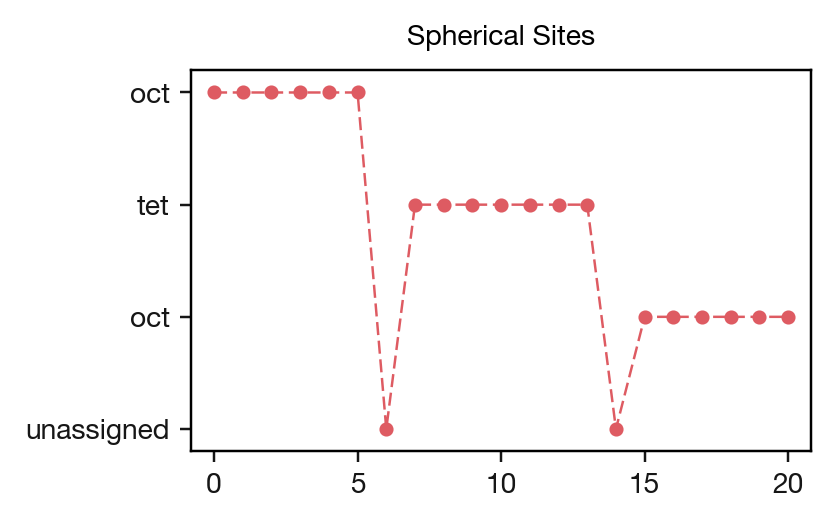

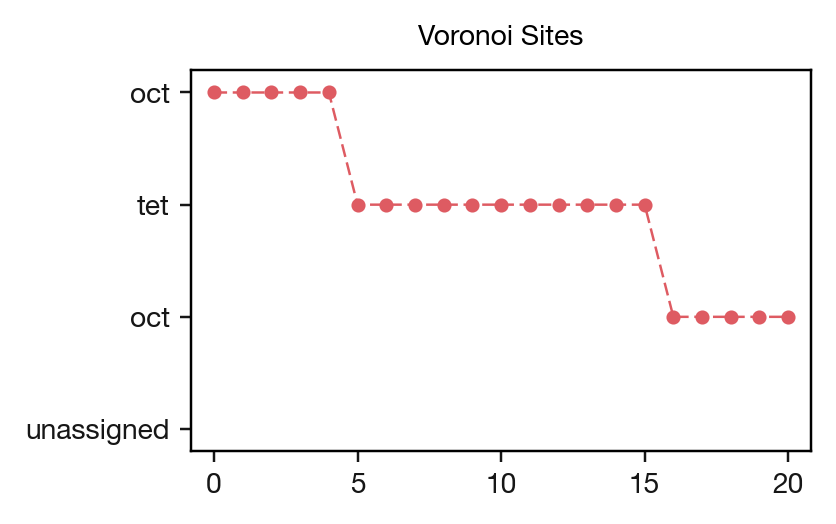

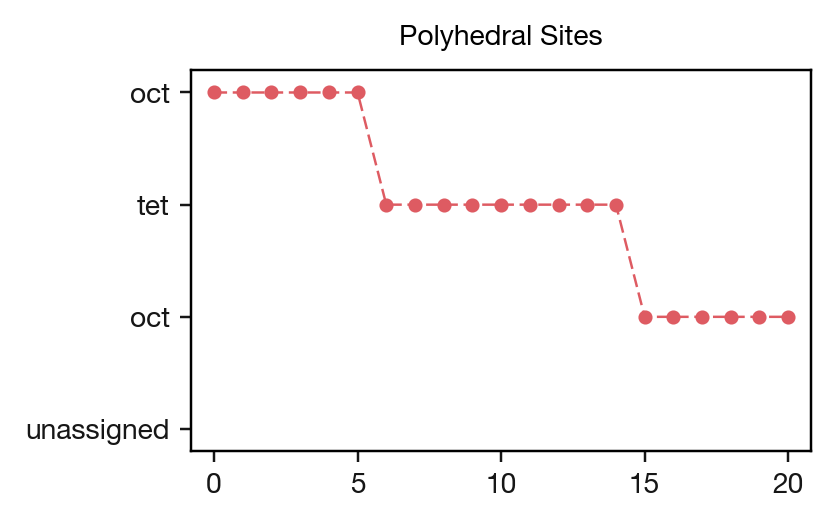

In [9]:
# we have the same site indices in all three analyses so we can use any
# of these to map from site indices to site type
site_types = {i: trajectory.sites[i].label for i in set(polyhedral_trajectory)}
site_index = {17: 1,
              283: 2,
              70: 3,
              None: 0}

trajectories = {'Spherical Sites': spherical_trajectory,
                'Voronoi Sites': voronoi_trajectory,
                'Polyhedral Sites': polyhedral_trajectory}

for title, traj in trajectories.items():
    plt.plot([site_index[i] for i in traj], 'o--', markersize=3, color=ff.tableauP['red'])
    plt.yticks([0,1,2,3], ['unassigned', 'oct', 'tet', 'oct'])
    plt.xticks(list(range(0, 21,5)))
    plt.ylim(-0.2, 3.2)
    plt.xlim(-0.8, 20.8)
    plt.title(title, loc='center')
    plt.show()

## Analysis

When tracking ion migration through crystalline materials, the choice of site definition methodology can significantly impact the interpretation of results. Our comparison of three different site definition approaches reveals important insights:

### Overall Trajectory
All three methods—spherical, Voronoi, and polyhedral—successfully capture the essential path of the lithium ion: starting in an octahedral site, passing through a tetrahedral site, and ending in another octahedral site. 

### Space-Filling Properties
A key difference emerges in how these methods handle the space between defined sites:

Spherical sites do not completely fill space. Our chosen sphere radii (inradii of the octahedra and tetrahedra) leave gaps between sites. Consequently, at frames 6 and 14, the lithium ion occupies regions not covered by any site definition, appearing as "unassigned" periods during transitions.

Voronoi sites partition the entire space based on proximity to site centers. Every point in space is assigned to the closest site center, eliminating unassigned regions. This ensures the ion is always associated with a site throughout the trajectory.

Polyhedral sites similarly fill space completely through their face-sharing structure, ensuring continuous site assignment.

### Transition Timing
The different methods show variations in when transitions between sites occur:

With spherical sites, transitions appear abrupt with unassigned regions in between, suggesting a clearer distinction between being "in" or "out" of a site.

For Voronoi sites, a transition occurs when the ion crosses a boundary surface that is equidistant from neighboring site centers (essentially the perpendicular bisector plane between centers). This results in earlier transitions from octahedral to tetrahedral sites compared to the polyhedral method.

With polyhedral sites, transitions occur when the ion moves through the shared face between polyhedra. This geometric definition creates a different boundary than the Voronoi approach, leading to slightly different transition times.

### Practical Implications
These differences highlight important considerations when analysing ion mobility:

Spherical sites may be simplest to implement but can miss periods of the trajectory during transitions, potentially losing information about transition states.

Voronoi sites ensure complete tracking but define boundaries purely based on proximity without considering the actual coordinating environment of the ion.

Polyhedral sites consider the actual coordination environment and may provide more physically meaningful boundaries, though they require more complex implementation.